In [1]:
#############################################   importing packages     #############################################
import sqlite3
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import os 
from matplotlib_venn import venn3
import pyper as pr
import statistics

def conditions(s):
    if s['VITALSTATUS'] == 'D':
        return(1)
    elif s['VITALSTATUS'] == 'A':
        return(0)

# Change the working directory to connect to the database
print(os.getcwd())
os.chdir('/data/master/DS175/share/0_Database')
print(os.getcwd())

# Connect to the database
conn = sqlite3.connect('Gliocova.db')
cur = conn.cursor()
df = pd.read_sql("SELECT * FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (GRADE IN ('G2','G3','GX','')) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_') AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_');",conn)
df.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
df['PSEUDO_PATIENTID'].nunique()


/data/master/DS175/share/19_Rare tumours
/data/master/DS175/share/0_Database


1287

In [2]:
tum_pat = pd.read_sql('SELECT * FROM TUM_PAT;', conn)
multi_oligo=tum_pat[tum_pat['PSEUDO_PATIENTID'].isin(df['PSEUDO_PATIENTID'])]
multi_oligo.groupby('MORPH_ICD10_O2')['PSEUDO_PATIENTID'].nunique()

MORPH_ICD10_O2
9380      1
9382      1
9401      3
9420      1
9440      5
9450    773
9451    522
9530      2
9537      1
Name: PSEUDO_PATIENTID, dtype: int64

In [3]:
EX=('9380', '9382', '9401', '9420', '9440', '9530', '9537')

oligo_withOther=multi_oligo.query('MORPH_ICD10_O2 in @EX') 
print('patient number with mixed tumour', oligo_withOther['PSEUDO_PATIENTID'].nunique())

patient number with mixed tumour 14


In [4]:
df=multi_oligo[~multi_oligo['PSEUDO_PATIENTID'].isin(oligo_withOther['PSEUDO_PATIENTID'])]
df.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)

# drop NA of INTERVAL
df['INTERVAL_DIAG_TO_VS'].replace('', np.nan,inplace=True)
df.dropna(subset='INTERVAL_DIAG_TO_VS', inplace=True)
df['VITALSTATUS'].replace('', np.nan,inplace=True)
df.dropna(subset='VITALSTATUS', inplace=True)
df['PSEUDO_PATIENTID'].nunique()

/tmp/ipykernel_637725/4103953176.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
/tmp/ipykernel_637725/4103953176.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INTERVAL_DIAG_TO_VS'].replace('', np.nan,inplace=True)
/tmp/ipykernel_637725/4103953176.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset='INTERVAL_DIAG_TO_VS', inplace=True)
/tmp/ipyker

1271

## df for Surgery

In [5]:
## build df of HESAPC, SACT and RTDS
surgery=('A012', 'A013', 'A018', 'A019', 'A021', 'A022', 'A023', 'A024', 'A025', 'A026', 'A027', 'A028', 
         'A029', 'A073', 'A078', 'A108', 'A118', 'A168', 'A171', 'A208', 'A291', 'A293', 'A295', 'A298',
         'A381', 'A382', 'A383', 'A384', 'A385', 'A386', 'A388', 'A389', 'A428', 'A431', 'A432', 'A438',
         'A441', 'A442', 'A443', 'A444', 'A445', 'A448', 'A449', 'A511', 'A518', 'A571', 'A599', 'A611', 
         'B012', 'B068', 'C021', 'E158', 'T962', 'V031', 'V038', 'V039', 'V051', 'V058', 'V431', 'V433', 
         'V498', 'V499', 'Y059', 'Y068', 'Y069', 'Y461', 'Y463', 'Y464', 'Y465', 'Y467', 'Y468', 'Y469')

biopsy=('A041', 'A042', 'A043', 'A044', 'A045', 'A046', 'A048', 'A049', 'A081', 'A082', 'A083', 'A084', 
         'A085', 'A086', 'A088', 'A089', 'A104', 'A105', 'A181', 'A188', 'A363', 'A422', 'A454', 'A456', 
         'A481', 'A482', 'A513', 'A578', 'A731', 'B042', 'T968', 'V036', 'V052', 'Y201', 'Y202', 'Y208', 
         'Y462', 'Y466', 'Y471', 'Y472', 'Y473', 'Y474', 'Y475', 'Y476', 'Y478', 'Y479', 'Y698')

HESIP=pd.read_sql("SELECT * FROM HESAPC WHERE PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (GRADE IN ('G2','G3','GX','')) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (SEX IN (1,2)));",conn)
HESIP=pd.merge(HESIP,df,on='PSEUDO_PATIENTID')
print('Number of oligo patients in hes apc table :')
    
print(HESIP['PSEUDO_PATIENTID'].nunique())
HESIP['id'] = HESIP.index

# reshape the dataframe to make the surgeries in one column 
HESNEW = pd.wide_to_long(HESIP,['OPERTN_','DAY_FROM_DIAG_TO_OP_'], i="id",j="column number")
    
print('Number of oligo patients in hes apc table :',HESNEW['PSEUDO_PATIENTID'].nunique())


Number of oligo patients in hes apc table :
1262
Number of oligo patients in hes apc table : 1262


In [6]:
hes=HESNEW[['PSEUDO_PATIENTID', 'OPERTN_', 'DAY_FROM_DIAG_TO_OP_', 'INTERVAL_ADMISION_DISCHARGE']]
hes=hes.drop_duplicates()

## surgery and biopsy codes came from PHE, ICHT and GC  
oligo_biopsy = hes.query('OPERTN_ in @biopsy')
oligo_surgery = hes.query('OPERTN_ in @surgery')
print('biopsy oligo:', oligo_biopsy['PSEUDO_PATIENTID'].nunique())
print('Surgery oligo:', oligo_surgery['PSEUDO_PATIENTID'].nunique())

# use concat to get patient number who had undergone surgery or biopsy
surgery_or_bio=pd.concat([oligo_surgery, oligo_biopsy])

# use merge to get patient number who had undergone surgery and biopsy
surgery_and_bio=pd.merge(oligo_surgery, oligo_biopsy, on='PSEUDO_PATIENTID')

# merge with df to ensure Site Code in C71 C72 again
df_biopsy=pd.merge(oligo_biopsy, df, on='PSEUDO_PATIENTID')
df_surgery=pd.merge(oligo_surgery, df, on='PSEUDO_PATIENTID')

surgery_or_bio=pd.merge(surgery_or_bio, df, on='PSEUDO_PATIENTID')
surgery_and_bio=pd.merge(surgery_and_bio, df, on='PSEUDO_PATIENTID')

biopsy oligo: 644
Surgery oligo: 1015


In [7]:
surgery_or_bio['PSEUDO_PATIENTID'].nunique()

1192

## df for RTDS

In [8]:
radio_oligo = pd.read_sql("SELECT * FROM RTDS WHERE PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (GRADE IN ('G2', 'G3', 'GX','')) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) );",conn)
print('Total number of patients with oligodendro in RTDS table:', radio_oligo['PSEUDO_PATIENTID'].nunique())
radio_oligo.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)


Total number of patients with oligodendro in RTDS table: 823


In [9]:
radio_oligo['PRIMARYDIAGNOSISICD']=radio_oligo['PRIMARYDIAGNOSISICD'].astype(str)
radio_oligo['ICD10']=radio_oligo['PRIMARYDIAGNOSISICD'].astype(str).str[:3]

# Creating a dataframe that locks from the original dataframe the patient id and the new ICD10 column
radio_P=radio_oligo[['PSEUDO_PATIENTID','ICD10','INTERVAL_DIAG_TO_TREAT_START' ,'RTTREATMENTREGION', 'RTPRESCRIBEDDOSE','ACTUALFRACTIONS', 'RTACTUALDOSE']]

diagnosis=('C71', 'C72')
rtds=radio_P[radio_P.ICD10.isin(diagnosis)]
print('Number of patients that had an ICD 10 code of C71 or C72:', rtds['PSEUDO_PATIENTID'].nunique())

print('Number of patients without a brain tumour diagnosis in RTDS:', radio_oligo['PSEUDO_PATIENTID'].nunique() - rtds['PSEUDO_PATIENTID'].nunique())

# Creating a list with the values of the variable (region of treatment) that we want to get numbers for
primary=('P', 'R', 'PR')
# Creating a dataframe that retains only the rows with the values we selected before in the list
prim=rtds[rtds.RTTREATMENTREGION.isin(primary)]
# Printing the  number of patients assigned those selected treatments
print(prim['RTTREATMENTREGION'].value_counts())
print('Number of patients with a brain tumour diagnosis in RTDS receiving treatment to their primary site:', prim['PSEUDO_PATIENTID'].nunique())

Number of patients that had an ICD 10 code of C71 or C72: 791
Number of patients without a brain tumour diagnosis in RTDS: 32
P     759
PR      1
Name: RTTREATMENTREGION, dtype: int64
Number of patients with a brain tumour diagnosis in RTDS receiving treatment to their primary site: 760


In [10]:
## reassignment to radio_oligo
radio_oligo=pd.merge(prim,df,on='PSEUDO_PATIENTID')
radio_oligo['PSEUDO_PATIENTID'].nunique()

749

## df for SACT

In [11]:
# fetch the first 3 characters to get patients diagnosis code starting with C70/C71/C72
c_oligo = pd.read_sql("SELECT * FROM SACT WHERE PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (GRADE IN ('G2', 'G3', 'GX', '')) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)
c_oligo['PRIMARY_DIAGNOSIS']=c_oligo['PRIMARY_DIAGNOSIS'].astype(str)
c_oligo['site_ICD10']=c_oligo['PRIMARY_DIAGNOSIS'].astype(str).str[:3]

print('Patients number in SACT before cleaning:', c_oligo['PSEUDO_PATIENTID'].nunique())

# Choose the columns that we may need
chemo_icd=c_oligo[['PSEUDO_PATIENTID','site_ICD10','INTERVAL_DIAG_START_REGIMEN','INTENT_OF_TREATMENT','MORPHOLOGY_CLEAN', 'BENCHMARK_GROUP','CYCLE_NUMBER','INTERVAL_DIAG_START_CYCLE', 'DRUG_GROUP']]
chemo_icd.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)

# Selecting patients that have a brain tumour diagnosis code in SACT 
diagnosis=('C71', 'C72')
chemo_bt=chemo_icd[chemo_icd.site_ICD10.isin(diagnosis)]
print(chemo_bt['site_ICD10'].value_counts())
print('Number of patients with a brain tumour diagnosis in SACT:', chemo_bt['PSEUDO_PATIENTID'].nunique())

Patients number in SACT before cleaning: 749
C71    697
C72      3
Name: site_ICD10, dtype: int64
Number of patients with a brain tumour diagnosis in SACT: 700


/tmp/ipykernel_637725/371206213.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemo_icd.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)


In [12]:
## reassignment to chemo_oligo
chemo_oligo=pd.merge(chemo_bt, df, on='PSEUDO_PATIENTID')
chemo_oligo['PSEUDO_PATIENTID'].nunique()

691

In [13]:
# Use merge and isin() to build df, this comparison didn't consider 14 - 84 days interval == adjuvant chemotherapy, 
# post suegery 90 days, having RT and SACT the same time == chemo-radiotherapy
# Radical/palliative chemotherapy, immediately using drug after diag/using drug 90 days after surgery
# Radical/palliative radiotherapy, 40Gy threshold

# Exclude id in surgery df
radio_chemo=radio_oligo[radio_oligo['PSEUDO_PATIENTID'].isin(chemo_oligo['PSEUDO_PATIENTID'])]
radio_chemo=radio_chemo[~radio_chemo['PSEUDO_PATIENTID'].isin(HESNEW['PSEUDO_PATIENTID'])]

sur_chemo=HESNEW[HESNEW['PSEUDO_PATIENTID'].isin(chemo_oligo['PSEUDO_PATIENTID'])]
sur_chemo=sur_chemo[~sur_chemo['PSEUDO_PATIENTID'].isin(radio_oligo['PSEUDO_PATIENTID'])]

sur_radio=HESNEW[HESNEW['PSEUDO_PATIENTID'].isin(radio_oligo['PSEUDO_PATIENTID'])]
sur_radio=sur_radio[~sur_radio['PSEUDO_PATIENTID'].isin(chemo_oligo['PSEUDO_PATIENTID'])]

all_treatments = HESNEW[HESNEW['PSEUDO_PATIENTID'].isin(radio_oligo['PSEUDO_PATIENTID'])]
all_treatments = all_treatments[all_treatments['PSEUDO_PATIENTID'].isin(chemo_oligo['PSEUDO_PATIENTID'])]

no_treatment=df[~df['PSEUDO_PATIENTID'].isin(chemo_oligo['PSEUDO_PATIENTID'])]
no_treatment=no_treatment[~no_treatment['PSEUDO_PATIENTID'].isin(HESNEW['PSEUDO_PATIENTID'])]
no_treatment=no_treatment[~no_treatment['PSEUDO_PATIENTID'].isin(radio_oligo['PSEUDO_PATIENTID'])]

print('Patients only had Chemo/radio therapy', radio_chemo['PSEUDO_PATIENTID'].nunique())
print('Patients only had surgery and chemotherapy', sur_chemo['PSEUDO_PATIENTID'].nunique())
print('Patients only had surgery and radiotherapy', sur_radio['PSEUDO_PATIENTID'].nunique())
print('Patients only had all 3 treatments', all_treatments['PSEUDO_PATIENTID'].nunique())
print('Patients had no treatments', no_treatment['PSEUDO_PATIENTID'].nunique())


Patients only had Chemo/radio therapy 2
Patients only had surgery and chemotherapy 144
Patients only had surgery and radiotherapy 202
Patients only had all 3 treatments 545
Patients had no treatments 7


Text(0.5, 1.0, 'Survival of oligo patients by different treatments')

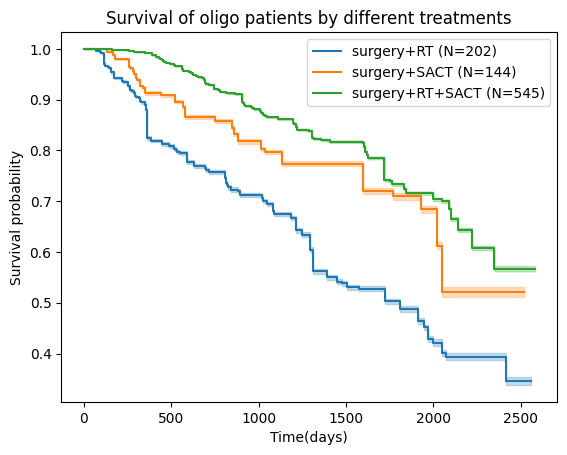

In [14]:
kmf=KaplanMeierFitter()
sur_radio['VITALSTATUS_NEW'] = sur_radio.apply(conditions, axis = 1)
kmf.fit(durations = sur_radio['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = sur_radio['VITALSTATUS_NEW'].astype(int), label = 'surgery+RT (N=202)')
kmf.plot()

sur_chemo['VITALSTATUS_NEW'] = sur_chemo.apply(conditions, axis = 1)
kmf.fit(durations = sur_chemo['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = sur_chemo['VITALSTATUS_NEW'].astype(int), label = 'surgery+SACT (N=144)')
kmf.plot()

all_treatments['VITALSTATUS_NEW'] = all_treatments.apply(conditions, axis = 1)
kmf.fit(durations = all_treatments['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = all_treatments['VITALSTATUS_NEW'].astype(int), label = 'surgery+RT+SACT (N=545)')
kmf.plot()

plt.xlabel('Time(days)')
plt.ylabel('Survival probability')
plt.title('Survival of oligo patients by different treatments')

In [15]:
all_SurSACT_results = logrank_test(all_treatments['INTERVAL_DIAG_TO_VS'], sur_chemo['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = all_treatments.apply(conditions,axis=1).astype(int),
                       event_observed_B = sur_chemo.apply(conditions,axis=1).astype(int))
all_SurSACT_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         949.19 <0.005    689.97

## To check if there is difference between grades

In [16]:
sur_radio_G2=sur_radio[sur_radio.GRADE=='G2']
sur_radio_G3=sur_radio[sur_radio.GRADE=='G3']

sur_chemo_G2=sur_chemo[sur_chemo.GRADE=='G2']
sur_chemo_G3=sur_chemo[sur_chemo.GRADE=='G3']

all_G2=all_treatments[all_treatments.GRADE=='G2']
all_G3=all_treatments[all_treatments.GRADE=='G3']

print(sur_radio_G2['PSEUDO_PATIENTID'].nunique())
print(sur_radio_G3['PSEUDO_PATIENTID'].nunique())

print(sur_chemo_G2['PSEUDO_PATIENTID'].nunique())
print(sur_chemo_G3['PSEUDO_PATIENTID'].nunique())

print(all_G2['PSEUDO_PATIENTID'].nunique())
print(all_G3['PSEUDO_PATIENTID'].nunique())


91
90
62
61
164
314


/tmp/ipykernel_637725/702328144.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sur_radio_G2['VITALSTATUS_NEW'] = sur_radio_G2.apply(conditions, axis = 1)
/tmp/ipykernel_637725/702328144.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sur_chemo_G2['VITALSTATUS_NEW'] = sur_chemo_G2.apply(conditions, axis = 1)
/tmp/ipykernel_637725/702328144.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Text(0.5, 1.0, 'Survival of G2 oligo patients by different treatment combinations')

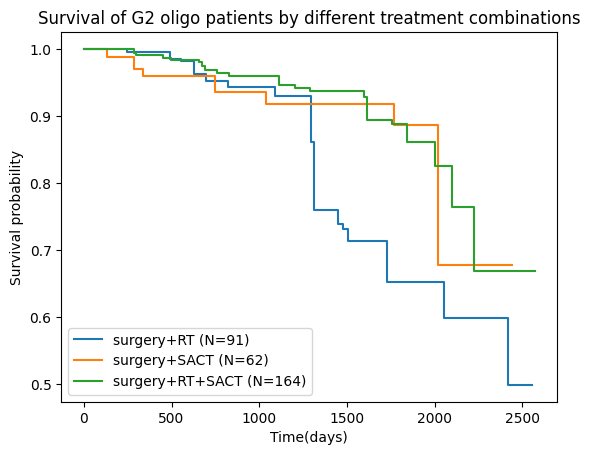

In [17]:
## G2
sur_radio_G2['VITALSTATUS_NEW'] = sur_radio_G2.apply(conditions, axis = 1)
kmf.fit(durations = sur_radio_G2['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = sur_radio_G2['VITALSTATUS_NEW'].astype(int), label = 'surgery+RT (N=91)')
kmf.plot(ci_show=False)

sur_chemo_G2['VITALSTATUS_NEW'] = sur_chemo_G2.apply(conditions, axis = 1)
kmf.fit(durations = sur_chemo_G2['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = sur_chemo_G2['VITALSTATUS_NEW'].astype(int), label = 'surgery+SACT (N=62)')
kmf.plot(ci_show=False)

all_G2['VITALSTATUS_NEW'] = all_G2.apply(conditions, axis = 1)
kmf.fit(durations = all_G2['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = all_G2['VITALSTATUS_NEW'].astype(int), label = 'surgery+RT+SACT (N=164)')
kmf.plot(ci_show=False)

plt.xlabel('Time(days)')
plt.ylabel('Survival probability')
plt.title('Survival of G2 oligo patients by different treatment combinations')


In [18]:
all_SurSACT_results = logrank_test(all_G2['INTERVAL_DIAG_TO_VS'], sur_chemo_G2['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = all_G2.apply(conditions,axis=1).astype(int),
                       event_observed_B = sur_chemo_G2.apply(conditions,axis=1).astype(int))
all_SurSACT_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          66.02 <0.005     50.99

/tmp/ipykernel_637725/103499366.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sur_radio_G3['VITALSTATUS_NEW'] = sur_radio_G3.apply(conditions, axis = 1)
/tmp/ipykernel_637725/103499366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sur_chemo_G3['VITALSTATUS_NEW'] = sur_chemo_G3.apply(conditions, axis = 1)
/tmp/ipykernel_637725/103499366.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Text(0.5, 1.0, 'Survival of G3 oligo patients by different treatment combinations')

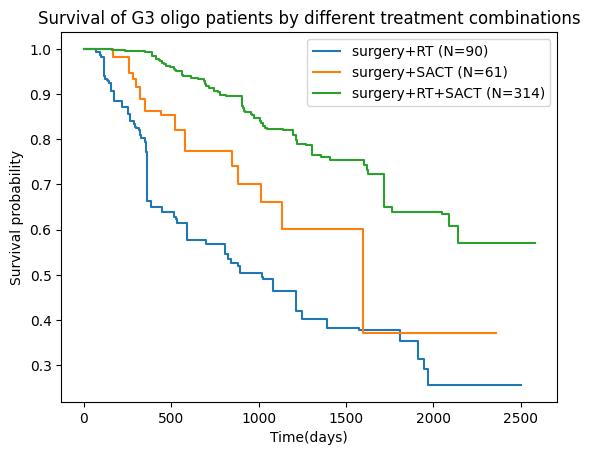

In [19]:
## G3
sur_radio_G3['VITALSTATUS_NEW'] = sur_radio_G3.apply(conditions, axis = 1)
kmf.fit(durations = sur_radio_G3['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = sur_radio_G3['VITALSTATUS_NEW'].astype(int), label = 'surgery+RT (N=90)')
kmf.plot(ci_show=False)

sur_chemo_G3['VITALSTATUS_NEW'] = sur_chemo_G3.apply(conditions, axis = 1)
kmf.fit(durations = sur_chemo_G3['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = sur_chemo_G3['VITALSTATUS_NEW'].astype(int), label = 'surgery+SACT (N=61)')
kmf.plot(ci_show=False)

all_G3['VITALSTATUS_NEW'] = all_G3.apply(conditions, axis = 1)
kmf.fit(durations = all_G3['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = all_G3['VITALSTATUS_NEW'].astype(int), label = 'surgery+RT+SACT (N=314)')
kmf.plot(ci_show=False)

plt.xlabel('Time(days)')
plt.ylabel('Survival probability')
plt.title('Survival of G3 oligo patients by different treatment combinations')

In [20]:
all_SurSACT_results = logrank_test(all_G3['INTERVAL_DIAG_TO_VS'], sur_chemo_G3['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = all_G3.apply(conditions,axis=1).astype(int),
                       event_observed_B = sur_chemo_G3.apply(conditions,axis=1).astype(int))
all_SurSACT_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        3103.10 <0.005       inf

## seq part start

In [21]:
## drop NA for all_treatments and merge it with RT and SACT to compare date
all_treatments=pd.merge(all_treatments, radio_oligo,on='PSEUDO_PATIENTID')
all_treatments['INTERVAL_DIAG_TO_TREAT_START'].replace('', np.nan,inplace=True)
all_treatments.dropna(subset=['INTERVAL_DIAG_TO_TREAT_START'], inplace=True)

all_treatments=pd.merge(all_treatments, chemo_oligo,on='PSEUDO_PATIENTID')
all_treatments['INTERVAL_DIAG_START_REGIMEN'].replace('', np.nan,inplace=True)
all_treatments.dropna(subset=['INTERVAL_DIAG_START_REGIMEN'], inplace=True)

In [22]:
all_treatments['DAY_FROM_DIAG_TO_OP_'].replace('', np.nan,inplace=True)
all_treatments['DAY_FROM_DIAG_TO_OP_'].replace('-', np.nan,inplace=True)
all_treatments.dropna(subset=['DAY_FROM_DIAG_TO_OP_'], inplace=True)
all_treatments['PSEUDO_PATIENTID'].nunique()

543

In [23]:
# all_treatments['INTERVAL_DIAG_TO_TREAT_START'].astype(int)
# all_treatments['INTERVAL_DIAG_START_REGIMEN'].astype(int)
# all_treatments['DAY_FROM_DIAG_TO_OP_'].astype(int)

In [24]:
## 'DAY_FROM_DIAG_TO_OP_', suegery always starts first
## 14 - 84 days after RT == adjuvant chemotherapy, 
# post suegery 90 days, having RT and SACT the same time == chemo-radiotherapy
# Radical/palliative chemotherapy, immediately using drug after diag/using drug 90 days after surgery
# Radical/palliative radiotherapy, 40Gy threshold

In [25]:
## build a df for Surgery alone group
Surgery_only=HESNEW[~HESNEW['PSEUDO_PATIENTID'].isin(chemo_oligo['PSEUDO_PATIENTID'])]
surgery_only=Surgery_only[~Surgery_only['PSEUDO_PATIENTID'].isin(radio_oligo['PSEUDO_PATIENTID'])]
surgery_only['PSEUDO_PATIENTID'].nunique()

371

In [26]:
######################################## sequence part starts here ##################################################
##### Radical/Palliative RT classifcication were not considered since most patients did not reach prescribed dose #########

# creating a new column for Residue from radiotherapy start - surgery start
all_treatments['s_r_diff']= all_treatments['INTERVAL_DIAG_TO_TREAT_START'] - all_treatments['DAY_FROM_DIAG_TO_OP_']
# Same for SACT
all_treatments['s_c_diff']= all_treatments['INTERVAL_DIAG_START_REGIMEN'] - all_treatments['DAY_FROM_DIAG_TO_OP_']
# also build for comparison between RT and SACT
all_treatments['r_c_diff']= all_treatments['INTERVAL_DIAG_START_REGIMEN'] - all_treatments['INTERVAL_DIAG_TO_TREAT_START']

# get Surgery + Chemo_radiotherapy + RT group step by step
SCr = all_treatments.query('-15 < r_c_diff < 15')
SCr = SCr.query('s_c_diff > 0' and 's_r_diff > 0')
SCr = SCr.query('r_c_diff > -1094' and 'r_c_diff < 1094')

# get Surgery + Adjuvant chemotherapy group step by step
SAc = all_treatments.query('r_c_diff < 85')
SAc = SAc.query('r_c_diff > 14')
SAc = SAc.query('r_c_diff > -1094' and 'r_c_diff < 1094')

# get Radical Chemotherapy + RT group step by step
RC = all_treatments.query('INTERVAL_DIAG_START_REGIMEN < 91')
RC = RC.query('r_c_diff > -1094' and 'r_c_diff < 1094')

# get Palliative Chemotherapy + RT group step by step
PC = all_treatments.query('INTERVAL_DIAG_START_REGIMEN > 89')
PC = PC.query('r_c_diff > -1094' and 'r_c_diff < 1094')
PC = PC.query('s_c_diff < 0')
PC = PC.query('r_c_diff < 0')


In [27]:
# each groups' count
print('Surgery + Chemo_radiotherapy', SCr['PSEUDO_PATIENTID'].nunique())
print('Surgery + Adjuvant chemotherapy + RT', SAc['PSEUDO_PATIENTID'].nunique())
print('Surgery + Radical Chemotherapy', RC['PSEUDO_PATIENTID'].nunique())
print('Surgery + Palliative Chemotherapy', PC['PSEUDO_PATIENTID'].nunique())


Surgery + Chemo_radiotherapy 71
Surgery + Adjuvant chemotherapy + RT 209
Surgery + Radical Chemotherapy 82
Surgery + Palliative Chemotherapy 25


/tmp/ipykernel_637725/2036945469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surgery_only['VITALSTATUS_NEW'] = surgery_only.apply(conditions, axis = 1)


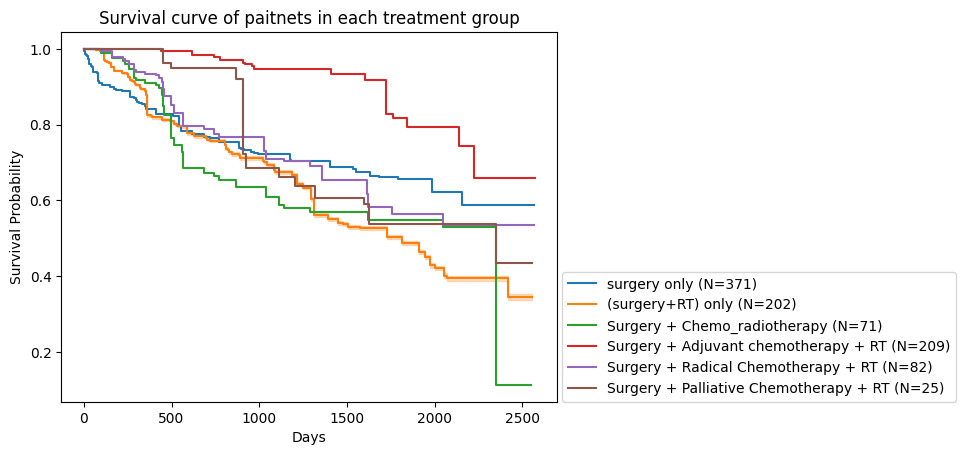

In [28]:
surgery_only['VITALSTATUS_NEW'] = surgery_only.apply(conditions, axis = 1)
kmf.fit(durations = surgery_only['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = surgery_only['VITALSTATUS_NEW'].astype(int), label = 'surgery only (N=371)')
kmf.plot(ci_show=False)

sur_radio['VITALSTATUS_NEW'] = sur_radio.apply(conditions, axis = 1)
kmf.fit(durations = sur_radio['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = sur_radio['VITALSTATUS_NEW'].astype(int), label = '(surgery+RT) only (N=202)')
kmf.plot()

# sur_chemo['VITALSTATUS_NEW'] = sur_chemo.apply(conditions, axis = 1)
# kmf.fit(durations = sur_chemo['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = sur_chemo['VITALSTATUS_NEW'].astype(int), label = '(surgery+Chemotherapy) only (N=144)')
# kmf.plot()
SCr['VITALSTATUS_NEW'] = SCr.apply(conditions, axis = 1)
kmf.fit(durations = SCr['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = SCr['VITALSTATUS_NEW'].astype(int), label = 'Surgery + Chemo_radiotherapy (N=71)')
kmf.plot(ci_show=False)

SAc['VITALSTATUS_NEW'] = SAc.apply(conditions, axis = 1)
kmf.fit(durations = SAc['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = SAc['VITALSTATUS_NEW'].astype(int), label = 'Surgery + Adjuvant chemotherapy + RT (N=209)')
kmf.plot(ci_show=False)

RC['VITALSTATUS_NEW'] = RC.apply(conditions, axis = 1)
kmf.fit(durations = RC['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = RC['VITALSTATUS_NEW'].astype(int), label = 'Surgery + Radical Chemotherapy + RT (N=82)')
kmf.plot(ci_show=False)

PC['VITALSTATUS_NEW'] = PC.apply(conditions, axis = 1)
kmf.fit(durations = PC['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = PC['VITALSTATUS_NEW'].astype(int), label = 'Surgery + Palliative Chemotherapy + RT (N=25)')
kmf.plot(ci_show=False)

# no_treatment['VITALSTATUS_NEW'] = no_treatment.apply(conditions, axis = 1)
# kmf.fit(durations = no_treatment['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = no_treatment['VITALSTATUS_NEW'].astype(int), label = 'No Surgery, no Chemotherapy, no RT (N=7)')
# kmf.plot(ci_show=False)

plt.xlabel('Days')
plt.title('Survival curve of paitnets in each treatment group')
plt.ylabel('Survival Probability')
plt.legend(bbox_to_anchor=(1.01,0), loc=3, borderaxespad=0)



## Try using intent of treatment to define Adjuvant/radical/palliative Chemo

In [29]:
Adju=('A', 'N')
# get Surgery + Adjuvant chemotherapy group step by step
SAc = all_treatments[all_treatments.INTENT_OF_TREATMENT.isin(Adju)]

# get Radical Chemotherapy + RT group step by step
RC = all_treatments[all_treatments.INTENT_OF_TREATMENT=='C']

# get Palliative Chemotherapy + RT group step by step
PC = all_treatments[all_treatments.INTENT_OF_TREATMENT=='P']


In [30]:
print('Surgery + Adjuvant chemotherapy + RT', SAc['PSEUDO_PATIENTID'].nunique())
print('Surgery + Radical Chemotherapy', RC['PSEUDO_PATIENTID'].nunique())
print('Surgery + Palliative Chemotherapy', PC['PSEUDO_PATIENTID'].nunique())

Surgery + Adjuvant chemotherapy + RT 325
Surgery + Radical Chemotherapy 71
Surgery + Palliative Chemotherapy 88


/tmp/ipykernel_637725/678833351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surgery_only['VITALSTATUS_NEW'] = surgery_only.apply(conditions, axis = 1)
/tmp/ipykernel_637725/678833351.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SAc['VITALSTATUS_NEW'] = SAc.apply(conditions, axis = 1)
/tmp/ipykernel_637725/678833351.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

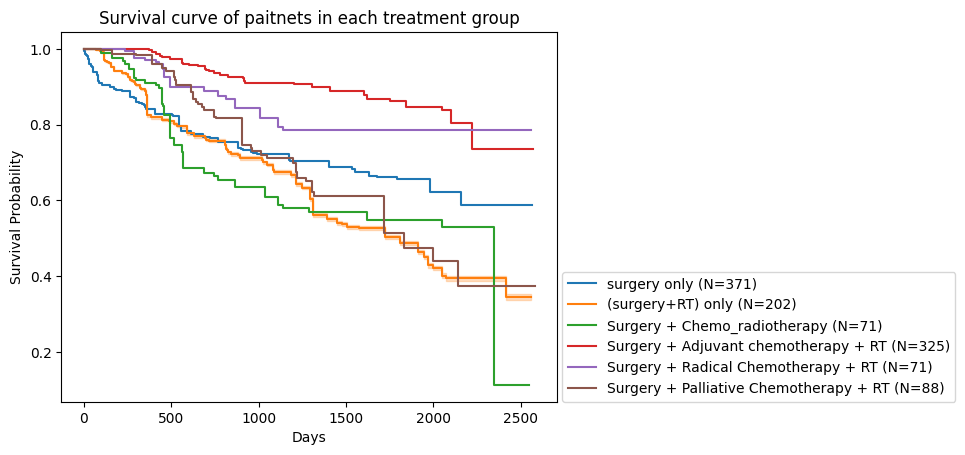

In [31]:
surgery_only['VITALSTATUS_NEW'] = surgery_only.apply(conditions, axis = 1)
kmf.fit(durations = surgery_only['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = surgery_only['VITALSTATUS_NEW'].astype(int), label = 'surgery only (N=371)')
kmf.plot(ci_show=False)

sur_radio['VITALSTATUS_NEW'] = sur_radio.apply(conditions, axis = 1)
kmf.fit(durations = sur_radio['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = sur_radio['VITALSTATUS_NEW'].astype(int), label = '(surgery+RT) only (N=202)')
kmf.plot()

# sur_chemo['VITALSTATUS_NEW'] = sur_chemo.apply(conditions, axis = 1)
# kmf.fit(durations = sur_chemo['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = sur_chemo['VITALSTATUS_NEW'].astype(int), label = '(surgery+Chemotherapy) only (N=144)')
# kmf.plot()
SCr['VITALSTATUS_NEW'] = SCr.apply(conditions, axis = 1)
kmf.fit(durations = SCr['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = SCr['VITALSTATUS_NEW'].astype(int), label = 'Surgery + Chemo_radiotherapy (N=71)')
kmf.plot(ci_show=False)

SAc['VITALSTATUS_NEW'] = SAc.apply(conditions, axis = 1)
kmf.fit(durations = SAc['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = SAc['VITALSTATUS_NEW'].astype(int), label = 'Surgery + Adjuvant chemotherapy + RT (N=325)')
kmf.plot(ci_show=False)

RC['VITALSTATUS_NEW'] = RC.apply(conditions, axis = 1)
kmf.fit(durations = RC['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = RC['VITALSTATUS_NEW'].astype(int), label = 'Surgery + Radical Chemotherapy + RT (N=71)')
kmf.plot(ci_show=False)

PC['VITALSTATUS_NEW'] = PC.apply(conditions, axis = 1)
kmf.fit(durations = PC['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = PC['VITALSTATUS_NEW'].astype(int), label = 'Surgery + Palliative Chemotherapy + RT (N=88)')
kmf.plot(ci_show=False)

# no_treatment['VITALSTATUS_NEW'] = no_treatment.apply(conditions, axis = 1)
# kmf.fit(durations = no_treatment['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = no_treatment['VITALSTATUS_NEW'].astype(int), label = 'No Surgery, no Chemotherapy, no RT (N=7)')
# kmf.plot(ci_show=False)

plt.xlabel('Days')
plt.title('Survival curve of paitnets in each treatment group')
plt.ylabel('Survival Probability')
plt.legend(bbox_to_anchor=(1.01,0), loc=3, borderaxespad=0)

## Comparison of Curative/Palliative PCV,TMZ

In [32]:
c_pcv = pd.read_sql("SELECT * FROM SACT WHERE INTENT_OF_TREATMENT IN ('A', 'N', 'C') AND (BENCHMARK_GROUP IN ('PCV', 'LOMUSTINE + PROCARBAZINE + VINCRISTINE')) AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)
c_pcv=pd.merge(c_pcv,df,on='PSEUDO_PATIENTID')
diagnosis=('C71', 'C72')

c_pcv['PRIMARY_DIAGNOSIS']=c_pcv['PRIMARY_DIAGNOSIS'].astype(str)
c_pcv['site_ICD10']=c_pcv['PRIMARY_DIAGNOSIS'].astype(str).str[:3]
c_pcv=c_pcv[c_pcv.site_ICD10.isin(diagnosis)]
c_pcv.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
c_pcv['PSEUDO_PATIENTID'].nunique()


341

In [33]:
p_pcv = pd.read_sql("SELECT * FROM SACT WHERE (PRIMARY_DIAGNOSIS LIKE 'C71_' or 'C72_') AND INTENT_OF_TREATMENT IN ('P') AND BENCHMARK_GROUP IN ('PCV', 'LOMUSTINE + PROCARBAZINE + VINCRISTINE') AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)
p_pcv=pd.merge(p_pcv,df,on='PSEUDO_PATIENTID')
p_pcv.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
p_pcv['PSEUDO_PATIENTID'].nunique()

97

In [34]:
c_tmz = pd.read_sql("SELECT * FROM SACT WHERE INTENT_OF_TREATMENT IN ('A', 'N', 'C') AND (PRIMARY_DIAGNOSIS LIKE 'C71_' or 'C72_') AND (BENCHMARK_GROUP IN ('TEMOZOLOMIDE', 'TEMOZOLOMIDE + RT')) AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)
c_tmz = pd.merge(c_tmz, df, on = 'PSEUDO_PATIENTID')

c_tmz.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
c_tmz['PSEUDO_PATIENTID'].nunique()

154

In [35]:
p_tmz = pd.read_sql("SELECT * FROM SACT WHERE INTENT_OF_TREATMENT IN ('P') AND (PRIMARY_DIAGNOSIS LIKE 'C71_' or 'C72_') AND (BENCHMARK_GROUP IN ('TEMOZOLOMIDE', 'TEMOZOLOMIDE + RT')) AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)
p_tmz = pd.merge(p_tmz, df, on = 'PSEUDO_PATIENTID')

p_tmz.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
p_tmz['PSEUDO_PATIENTID'].nunique()

116

## they should have surgery as standard treatment

In [36]:
p_pcv=p_pcv[p_pcv['PSEUDO_PATIENTID'].isin(surgery_or_bio['PSEUDO_PATIENTID'])]
c_pcv=c_pcv[c_pcv['PSEUDO_PATIENTID'].isin(surgery_or_bio['PSEUDO_PATIENTID'])]

p_tmz=p_tmz[p_tmz['PSEUDO_PATIENTID'].isin(surgery_or_bio['PSEUDO_PATIENTID'])]
c_tmz=c_tmz[c_tmz['PSEUDO_PATIENTID'].isin(surgery_or_bio['PSEUDO_PATIENTID'])]


In [37]:
rt_only=radio_oligo[~radio_oligo['PSEUDO_PATIENTID'].isin(chemo_oligo['PSEUDO_PATIENTID'])]
rt_only=rt_only[rt_only['PSEUDO_PATIENTID'].isin(surgery_or_bio['PSEUDO_PATIENTID'])]

In [38]:
p_pcv['PSEUDO_PATIENTID'].nunique()

94

In [39]:
c_pcv['PSEUDO_PATIENTID'].nunique()

334

In [40]:
p_tmz['PSEUDO_PATIENTID'].nunique()

109

In [41]:
c_tmz['PSEUDO_PATIENTID'].nunique()

152

In [42]:
rt_only['PSEUDO_PATIENTID'].nunique()

195

Text(0, 0.5, 'Survival Probability')

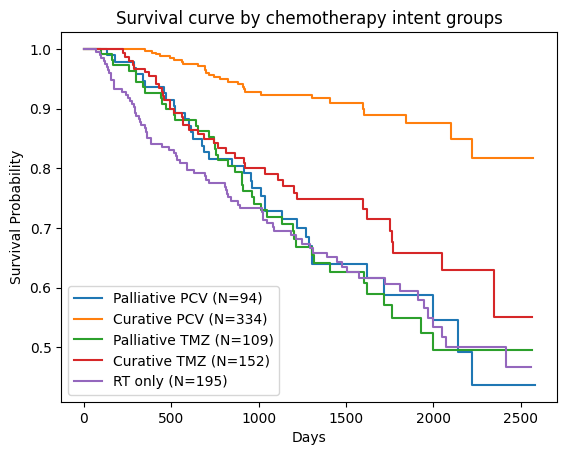

In [45]:
p_pcv['VITALSTATUS_NEW'] = p_pcv.apply(conditions, axis = 1)
ppcv=kmf.fit(durations = p_pcv['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = p_pcv['VITALSTATUS_NEW'].astype(int), label = 'Palliative PCV (N=94)')
kmf.plot(ci_show=False)

c_pcv['VITALSTATUS_NEW'] = c_pcv.apply(conditions, axis = 1)
cpcv=kmf.fit(durations = c_pcv['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = c_pcv['VITALSTATUS_NEW'].astype(int), label = 'Curative PCV (N=334)')
kmf.plot(ci_show=False)

p_tmz['VITALSTATUS_NEW'] = p_tmz.apply(conditions, axis = 1)
ptmz=kmf.fit(durations = p_tmz['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = p_tmz['VITALSTATUS_NEW'].astype(int), label = 'Palliative TMZ (N=109)')
kmf.plot(ci_show=False)

c_tmz['VITALSTATUS_NEW'] = c_tmz.apply(conditions, axis = 1)
ctmz=kmf.fit(durations = c_tmz['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = c_tmz['VITALSTATUS_NEW'].astype(int), label = 'Curative TMZ (N=152)')
kmf.plot(ci_show=False)

rt_only['VITALSTATUS_NEW'] = rt_only.apply(conditions, axis = 1)
rt=kmf.fit(durations = rt_only['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = rt_only['VITALSTATUS_NEW'].astype(int), label = 'RT only (N=195)')
kmf.plot(ci_show=False)

plt.xlabel('Days')
plt.title('Survival curve by chemotherapy intent groups')
plt.ylabel('Survival Probability')
# plt.legend(bbox_to_anchor=(1.01,0), loc=3, borderaxespad=0)

In [46]:
results = logrank_test(c_tmz['INTERVAL_DIAG_TO_VS'], rt_only['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = c_tmz.apply(conditions,axis=1).astype(int),
                       event_observed_B = rt_only.apply(conditions,axis=1).astype(int))
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.79 0.05      4.28

In [47]:
results = logrank_test(c_tmz['INTERVAL_DIAG_TO_VS'], p_pcv['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = c_tmz.apply(conditions,axis=1).astype(int),
                       event_observed_B = p_pcv.apply(conditions,axis=1).astype(int))
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.65 0.20      2.33

In [48]:
results = logrank_test(c_tmz['INTERVAL_DIAG_TO_VS'], p_tmz['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = c_tmz.apply(conditions,axis=1).astype(int),
                       event_observed_B = p_tmz.apply(conditions,axis=1).astype(int))
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.23 0.14      2.89